# StellarGraph examples

The StellarGraph object is a subclass of NetworkX MultiGraph, and has all the features built into NetworkX.


Import NetworkX and stellar:

In [1]:
import networkx as nx
from stellar.data.stellargraph import *
from stellar.data.loader import *

In [2]:
%reload_ext autoreload
%autoreload 2

## Creating graphs

We can create StellarGraph objects from NetworkX graphs:

In [3]:
G = StellarGraph(nx.karate_club_graph())

If not specified by an existing node/edge attributes, the node/edge types will default to be empty strings:

In [4]:
sg = G.create_graph_schema()
print(sg.node_types)
print(sg.edge_types)

['']
[EdgeType(n1='', rel='', n2='')]


### Heterogeneous graphs

To create a heterogenous graph we need to specify node and/or edge labels:

In [13]:
G = StellarGraph()
G.add_nodes_from([0, 1, 2, 3], label="movie")
G.add_nodes_from([4, 5], label="user")
e_keys = G.add_edges_from([(0, 4), (1, 4), (1, 5), (2, 4), (3, 5)], label="rating")

We can query the object to find more information about the Graph types

In [14]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 6, Edges: 5

 Node types:
  movie: [4]
    Edge types: movie-rating->user
  user: [2]
    Edge types: user-rating->movie

 Edge types:
    movie-rating->user: [5]



Add some more edges to form a real multigraph

In [15]:
e_keys = G.add_edges_from([(0, 4), (1, 4)], label="another")
e_keys = G.add_edges_from([(4, 5)], label="friend")

In [16]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 6, Edges: 8

 Node types:
  movie: [4]
    Edge types: movie-another->user, movie-rating->user
  user: [2]
    Edge types: user-another->movie, user-friend->user, user-rating->movie

 Edge types:
    movie-another->user: [2]
    movie-rating->user: [5]
    user-friend->user: [1]



## Loading graphs from different formats

EPGM formats are ideal for storing heterogeneous graphs. They are handled through a helper function:

In [62]:
graph_loc = "../tests/resources/data/yelp/yelp.epgm"
G = from_epgm(graph_loc, directed=True)

...reading ../tests/resources/data/yelp/yelp.epgm/graphs.json using utf-8 encoding...
...reading ../tests/resources/data/yelp/yelp.epgm/vertices.json using utf-8 encoding...
...reading ../tests/resources/data/yelp/yelp.epgm/edges.json using utf-8 encoding...
Converting the EPGM graph 59be1422c4785d276d9c3658 to NetworkX graph...
Graph statistics: 621 nodes, 6832 edges


In [18]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 621, Edges: 6832

 Node types:
  business: [10]
        Attributes: {'DogsAllowed', 'Alcohol', 'DriveThru', 'name', 'WiFi', 'state', 'yelpId', 'HappyHour', 'Smoking', 'HasTV', 'RestaurantsPriceRange2', 'city', 'BusinessAcceptsCreditCards', 'NoiseLevel', 'categories', 'BikeParking', 'stars', 'GoodForKids'}
    Edge types: business-locatedIn->city
  city: [3]
        Attributes: {'name'}
    Edge types: city-state->state
  review: [37]
        Attributes: {'useful', 'businessId', 'yelpId', 'userId', 'stars'}
    Edge types: review-towards->business
  state: [2]
        Attributes: {'name'}
    Edge types: 
  user: [569]
        Attributes: {'useful', 'funny', 'compliment_cool', 'compliment_more', 'compliment_profile', 'name', 'compliment_list', 'cool', 'compliment_cute', 'compliment_photos', 'yelpId', 'fans', 'compliment_writer', 'compliment_hot', 'average_stars', 'compliment_plain', 'compliment_funny', 'elite', 'compliment_note'}
    Edge type

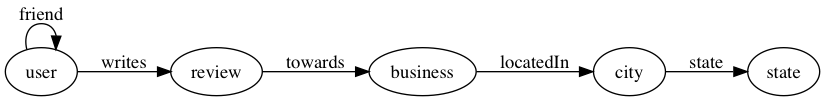

In [63]:
from graphviz import Digraph
gs = G.create_graph_schema()
Gschema = Digraph(engine='dot')
Gschema.attr(rankdir='LR')
for node_inx in gs.schema.keys():
    Gschema.node(node_inx)
    
for edge_inxs in gs.schema.values():
    for et in edge_inxs:
        Gschema.edge(et[0], et[2], label=et[1])

from IPython.display import display_png
display_png(Gschema.pipe(format='png'), raw=True)

## Graph Schema

In [66]:
G = StellarGraph()
G.add_nodes_from([0, 1, 2, 3], label="movie")
G.add_nodes_from([4, 5], label="user")
e_keys = G.add_edges_from([(4, 0), (4, 1), (5, 1), (4, 2), (5, 3)], label="rating")
e_keys = G.add_edges_from([(0, 4), (1, 4)], label="another")
e_keys = G.add_edges_from([(4, 5)], label="friend")

The graph schema gives information on the node and edge types 

In [67]:
gs = G.create_graph_schema(create_type_maps=True)
gs

GraphSchema:
node type: movie
   movie -- another -> user
   movie -- rating -> user
node type: user
   user -- another -> movie
   user -- friend -> user
   user -- rating -> movie

Note that, as this is an undirected graph, we have edge types in both directions:

i.e. &emsp; `user -- rating -> movie` &emsp; as well as &emsp; `movie -- rating -> user`

If we convert it to a directional graph, we have the expected semantics of our edge types:

In [72]:
Gd = StellarDiGraph()
Gd.add_nodes_from([0, 1, 2, 3], label="movie")
Gd.add_nodes_from([4, 5], label="user")
e_keys = Gd.add_edges_from([(4, 0), (4, 1), (5, 1), (4, 2), (5, 3)], label="rating")
e_keys = Gd.add_edges_from([(0, 4), (1, 4)], label="stars")
e_keys = Gd.add_edges_from([(4, 5)], label="friend")

gsd = Gd.create_graph_schema()
gsd

GraphSchema:
node type: movie
   movie -- stars -> user
node type: user
   user -- friend -> user
   user -- rating -> movie

Would be nice to have simple functionality to draw the schema:

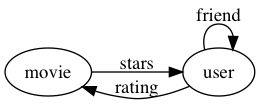

In [73]:
from graphviz import Digraph

Gschema = Digraph(engine='dot')
Gschema.attr(rankdir='LR')
for node_inx in gsd.schema.keys():
    Gschema.node(node_inx)
    
for edge_inxs in gsd.schema.values():
    for et in edge_inxs:
        
        Gschema.edge(et[0], et[2], label=et[1])

from IPython.display import display_png
display_png(Gschema.pipe(format='png'), raw=True)

---

The node edges and types are available. The ordering of these is important and maintained in all methods:

In [75]:
gsd.node_types

['movie', 'user']

In [76]:
gsd.edge_types

[EdgeType(n1='movie', rel='stars', n2='user'),
 EdgeType(n1='user', rel='friend', n2='user'),
 EdgeType(n1='user', rel='rating', n2='movie')]

The graph schema can be used to quickly look up node and edge types:

In [77]:
gsd.get_node_type(0)

'movie'

We can easily do filtering of nodes and edges based on types:

In [78]:
[ n for n in G if gs.get_node_type(n) == 'user' ]

[4, 5]

In [79]:
[ e for e in G.edges(keys=True) if gs.is_of_edge_type(e, ('movie', 'rating', 'user')) ]

[(0, 4, 0), (1, 4, 0), (1, 5, 0), (2, 4, 0), (3, 5, 0)]

This is a named tuple, so we can compare edges with tuples:

In [80]:
gs.get_edge_type((0,4,0)) == ('movie', 'rating', 'user')

True

But this doesn't work:

In [81]:
gs.get_edge_type((4,0,0)) == ('movie', 'rating', 'user')

False

In [82]:
gs.edge_types_for_node_type('user')

[EdgeType(n1='user', rel='another', n2='movie'),
 EdgeType(n1='user', rel='friend', n2='user'),
 EdgeType(n1='user', rel='rating', n2='movie')]

Or the sampling adjacency list schema (for GraphSAGE)

In [83]:
gs.schema['user']

[EdgeType(n1='user', rel='another', n2='movie'),
 EdgeType(n1='user', rel='friend', n2='user'),
 EdgeType(n1='user', rel='rating', n2='movie')]

In [85]:
gs.get_type_adjacency_list(['user', 'movie'], n_hops=1)

[('user', [2, 3, 4]),
 ('movie', [5, 6]),
 ('movie', []),
 ('user', []),
 ('movie', []),
 ('user', []),
 ('user', [])]

---

## Walkers and Mappers

In [27]:
from stellar.data.explorer import *

### Homogeneous Graph

In [28]:
G = StellarGraph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6], label="node")
e_keys = G.add_edges_from([(0, 3), (1, 2), (1, 3), (4, 5)], label="edge")

gs = G.create_graph_schema(create_type_maps=True)
gs

GraphSchema:
node type: node
   node -- edge -> node

In [29]:
walker = SampledBreadthFirstWalk(G)

In [30]:
node_samples = walker.run(nodes=[0, 1, 4], n_size=[2, 3])
node_samples

[[0, 3, 3, 1, 0, 0, 0, 0, 0],
 [1, 2, 2, 1, 1, 1, 1, 1, 1],
 [4, 5, 5, 4, 4, 4, 4, 4, 4]]

Proposed format:

In [31]:
def get_levels(samples_per_hop, walks):
    loc = 0
    ssize = 1
    lol_walks = [[] for ii in range(len(walks))]
    for nsamples in [1] + samples_per_hop:
        for ii in range(ssize):
            end_loc = loc + nsamples
            for ii in range(len(walks)):
                lol_walks[ii].append(walks[ii][loc:end_loc])
            loc = end_loc
        ssize = nsamples*ssize
    return lol_walks

get_levels([2,3], node_samples)

[[[0], [3, 3], [1, 0, 0], [0, 0, 0]],
 [[1], [2, 2], [1, 1, 1], [1, 1, 1]],
 [[4], [5, 5], [4, 4, 4], [4, 4, 4]]]

Isolated nodes:

In [34]:
node_samples = walker.run(nodes=[2, 6], n_size=[2, 2])

get_levels([2,3], node_samples)

[[[2], [1, 1], [2, 2, 3], [2]], [[6], [], [], []]]

### Heterogeneous graph

In [479]:
G = StellarGraph()
G.add_nodes_from([0, 1, 2, 3], label="movie")
G.add_nodes_from([4, 5], label="user")
e_keys = G.add_edges_from([(0, 4), (1, 4), (1, 5), (2, 4), (3, 5)], label="rating")
#e_keys = G.add_edges_from([(0, 4), (1, 4)], label="another")
e_keys = G.add_edges_from([(4, 5)], label="friend")

gs = G.create_graph_schema(create_type_maps=True)
gs

GraphSchema:
node type: movie
   movie -- rating -> user
node type: user
   user -- friend -> user
   user -- rating -> movie

In [475]:
G = StellarDiGraph()
G.add_nodes_from([0, 1, 2, 3], label="movie")
G.add_nodes_from([4, 5], label="user")
G.add_edges_from([(4, 0), (4, 1), (5, 1), (4, 2), (5, 3)], label="rating")

gs = G.create_graph_schema()
gs

GraphSchema:
node type: movie
node type: user
   user -- rating -> movie

In [480]:
gs.edge_types_for_node_type('user')

[EdgeType(n1='user', rel='friend', n2='user'),
 EdgeType(n1='user', rel='rating', n2='movie')]

In [481]:
gs.edge_types_for_node_type('movie')

[EdgeType(n1='movie', rel='rating', n2='user')]

In [482]:
gs.get_edge_type((0,4,0))

EdgeType(n1='movie', rel='rating', n2='user')

Sample nodes by edge type for each head node

First layer:
* sample from 'user' nodes

In [483]:
head_node_types = ['user']
edges_1 = [gs.edge_types_for_node_type(hn) for hn in head_node_types]
print(edges_1)

[[EdgeType(n1='user', rel='friend', n2='user'), EdgeType(n1='user', rel='rating', n2='movie')]]


Second layer:
* Sample from final node types: 'movie' and 'movie'

In [484]:
edges_2 = [gs.edge_types_for_node_type(et.n2) for edge_types in edges_1 for et in edge_types]
print(edges_2)

[[EdgeType(n1='user', rel='friend', n2='user'), EdgeType(n1='user', rel='rating', n2='movie')], [EdgeType(n1='movie', rel='rating', n2='user')]]


Expected node types for sampling:

In [485]:
head_node_types + [et.n2 for edge_types in edges_1 for et in edge_types] + [et.n2 for edge_types in edges_2 for et in edge_types]

['user', 'user', 'movie', 'user', 'movie', 'user']

Note this matches the expected node types for GraphSAGE

In [495]:
gs.get_type_adjacency_list(head_node_types, 2)

[('user', [1, 2]),
 ('user', [3, 4]),
 ('movie', [5]),
 ('user', []),
 ('movie', []),
 ('user', [])]

Therefore we can use the edge types given in `gs.edge_types_for_node_type` to sample nodes for HinSAGE:

In [494]:
head_nodes = [4]

het_samples = [head_nodes]
n_size = [2,3]
for ii,nsamples in enumerate(n_size):
    next_heads = []
    for hn in head_nodes:
        nt1 = gs.get_node_type(hn)
        edge_types = gs.edge_types_for_node_type(nt1)
        neighs = dict(G.adj[hn])
        print("sampling:", hn, nt1)
        for et in edge_types:
            neigh_et = [n2 for n2,nkeys in neighs.items() for k in iter(nkeys) if gs.is_of_edge_type((hn, n2, k), et)]
            samples = random.choices(neigh_et, k=nsamples) if len(neigh_et)>0 else []
            print("\t", et, neigh_et, samples)
            
            het_samples.append(samples)
            next_heads.extend(samples)
    head_nodes = next_heads
        

sampling: 4 user
	 EdgeType(n1='user', rel='friend', n2='user') [5] [5, 5]
	 EdgeType(n1='user', rel='rating', n2='movie') [0, 1, 2] [2, 2]
sampling: 5 user
	 EdgeType(n1='user', rel='friend', n2='user') [4] [4, 4, 4]
	 EdgeType(n1='user', rel='rating', n2='movie') [1, 3] [1, 1, 3]
sampling: 5 user
	 EdgeType(n1='user', rel='friend', n2='user') [4] [4, 4, 4]
	 EdgeType(n1='user', rel='rating', n2='movie') [1, 3] [3, 1, 1]
sampling: 2 movie
	 EdgeType(n1='movie', rel='rating', n2='user') [4] [4, 4, 4]
sampling: 2 movie
	 EdgeType(n1='movie', rel='rating', n2='user') [4] [4, 4, 4]


In [490]:
het_samples

[[4],
 [5, 5],
 [2, 2],
 [4, 4, 4],
 [1, 1, 1],
 [4, 4, 4],
 [1, 3, 3],
 [4, 4, 4],
 [4, 4, 4]]

## Graphs, targets and features for machine learning

Consider having targets and labels in the graph as node attributes, as in the case of the CORA graph

Load our graph (here from epgm)

In [ ]:
    # Function to convert labels to values for the Keras model
    target_to_value = TargetToNumeric(from_graph=G, target=target_attr, method='1hot')

    # Split head nodes into train/test
    splitter = NodeSplitter()
    graph_nodes = np.array(
        [(v, vdata.get(target_attr)) for v, vdata in G.nodes(data=True)]
    )
    train_nodes, val_nodes, test_nodes, _ = splitter.train_test_split(
        y=graph_nodes, p=50, test_size=1000
    )
    train_ids, train_labels = target_to_value.convert_node_label_pairs(train_nodes)


# TODO

Note that certain NX operations will return a NetworkX object, not a StellarGraph object:

In [8]:
print(nx.subgraph(G, [0]).__class__)
print(nx.to_directed(G).__class__)

<class 'networkx.classes.graphviews.SubMultiGraph'>
<class 'networkx.classes.graphviews.MultiDiGraphView'>


We should at least make the methods of StellarGraph return StellarGraph objects
(and let's add some more methods we should wrap):

In [10]:
print(G.copy().__class__)
print(G.to_directed().__class__)

<class 'networkx.classes.multigraph.MultiGraph'>
<class 'networkx.classes.multidigraph.MultiDiGraph'>


Nodes and edges have indices that should be extracted using the node_index and edge_index functions:

In [419]:
gs.node_index('movie')

0

In [420]:
gs.edge_index(('user', 'rating', 'movie'))

4

Note for an undirected graph the index is different for the inverse direction.

**TODO: Should we change this behaviour?**

In [421]:
gs.edge_index(('movie', 'rating', 'user'))

1

**TODO: StellarGraph assumes there is only a single edge with the same edge type between two nodes. Should we warn the users this isn't the case?**

This isn't enforced ATM so things may break if we add multiple edges with the same edge type, even though NetworkX supports this by creating a new edge key.

In [64]:
G.add_edges_from([(0,4)], label="another")
gs = G.create_graph_schema(create_type_maps=True)

KeyError: 'label'

In [65]:
[ e for e in G.edges(keys=True) if gs.get_edge_type(e) == ('movie', 'another', 'user') ]

[]